# N-BEATS 

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
df = pd.read_csv('data/daily_traffic.csv')

df.head()

,date_time,traffic_volume
0,9/29/2016 17:00,5551.0
1,9/29/2016 18:00,4132.0
2,9/29/2016 19:00,3435.0
3,9/29/2016 20:00,2765.0
4,9/29/2016 21:00,2443.0


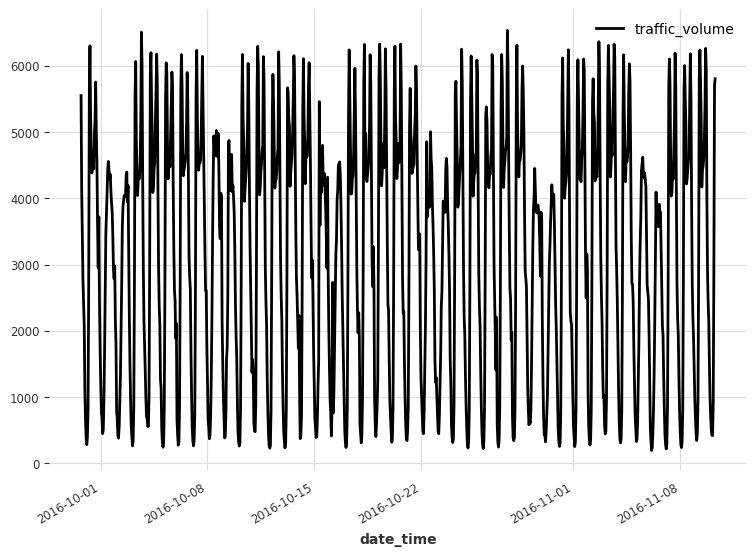

In [4]:
series = TimeSeries.from_dataframe(df, time_col='date_time')

series.plot()

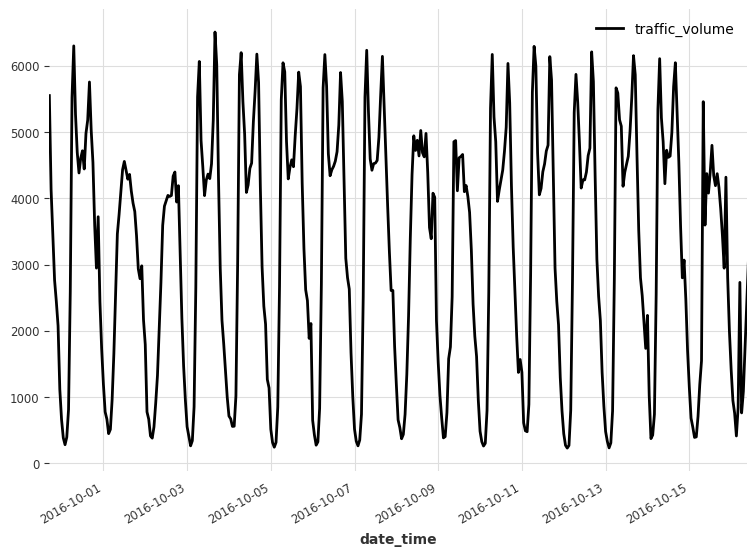

In [5]:
series.plot()
plt.xlim('9/29/2016 17:00', '10/16/2016 9:00');

In [6]:
from darts.utils.statistics import check_seasonality

is_daily_seasonal, daily_period = check_seasonality(series, m=24, max_lag=400, alpha=0.05)
is_weekly_seasonal, weekly_period = check_seasonality(series, m=168, max_lag=400, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')

Daily seasonality: True - period = 24
Weekly seasonality: True - period = 168


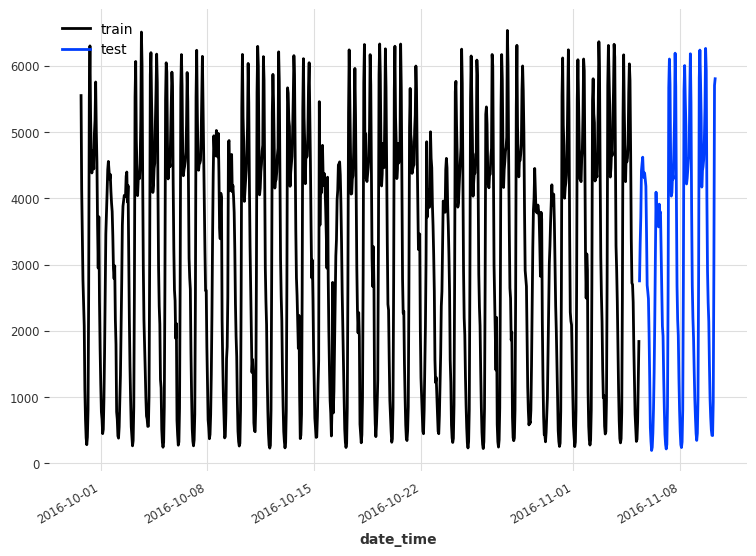

In [7]:
train, test = series[:-120], series[-120:]

train.plot(label='train')
test.plot(label='test')

## Baseline 

In [8]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=168)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(120)

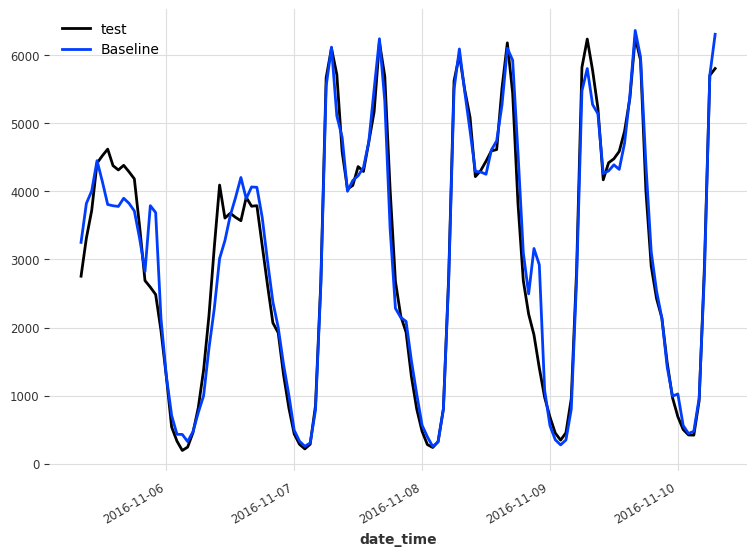

In [9]:
test.plot(label='test')
pred_naive.plot(label='Baseline')

In [10]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)

print(naive_mae)

249.09166666666667


## N-BEATS without covariates 

In [11]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

nbeats = NBEATSModel(
    input_chunk_length=168, 
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

nbeats.fit(
    scaled_train,
    epochs=50
)

2022-11-22 17:02:48 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-11-22 17:02:49 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-22 17:02:49 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-22 17:02:49 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-22 17:02:49 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.3 M 
---------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
58.647    Total estimated model params size (MB)


Epoch 49: 100%|███████████████████████████████████████| 22/22 [00:03<00:00,  7.31it/s, loss=0.0027, train_loss=0.00222]

2022-11-22 17:05:20 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|███████████████████████████████████████| 22/22 [00:03<00:00,  7.30it/s, loss=0.0027, train_loss=0.00222]


In [12]:
scaled_pred_nbeats = nbeats.predict(n=120)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


In [13]:
mae_nbeats = mae(test, pred_nbeats)

print(mae_nbeats)

292.3977035833977


## N-BEATS with covariates 

In [14]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = concatenate(
    [dt_attr(series.time_index, 'day', dtype=np.float32), dt_attr(series.time_index, 'week', dtype=np.float32)],
    axis='component'
)

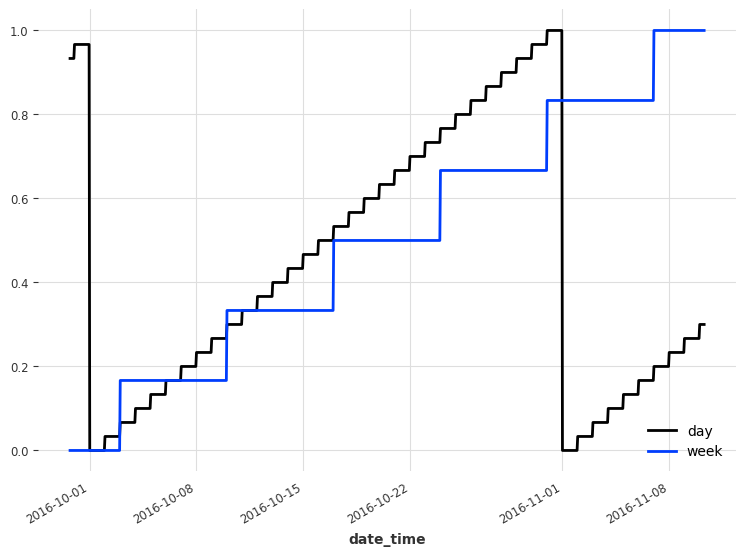

In [15]:
cov_scaler = Scaler()

scaled_cov = cov_scaler.fit_transform(cov)

train_scaled_cov, test_scaled_cov = scaled_cov[:-120], scaled_cov[-120:]

scaled_cov.plot()

In [16]:
nbeats_cov = NBEATSModel(
    input_chunk_length=168, 
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

nbeats_cov.fit(
    scaled_train,
    past_covariates=scaled_cov,
    epochs=50
)

2022-11-22 17:05:20 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-11-22 17:05:20 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-22 17:05:20 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-22 17:05:20 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-22 17:05:21 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.0 M
---------------------------------------------------
10.0 M    Trainable params
4.3 K     Non-trainable params
10.0 M    Total params
79.844    Total estimated model params size (MB)


Epoch 49: 100%|██████████████████████████████████████| 22/22 [00:03<00:00,  6.29it/s, loss=0.00235, train_loss=0.00281]

2022-11-22 17:08:17 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████████████████████████████████| 22/22 [00:03<00:00,  6.29it/s, loss=0.00235, train_loss=0.00281]


In [17]:
scaled_pred_nbeats_cov = nbeats_cov.predict(past_covariates=scaled_cov, n=120)

pred_nbeats_cov = train_scaler.inverse_transform(scaled_pred_nbeats_cov)

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


In [18]:
mae_nbeats_cov = mae(test, pred_nbeats_cov)

print(mae_nbeats_cov)

287.6306614724936


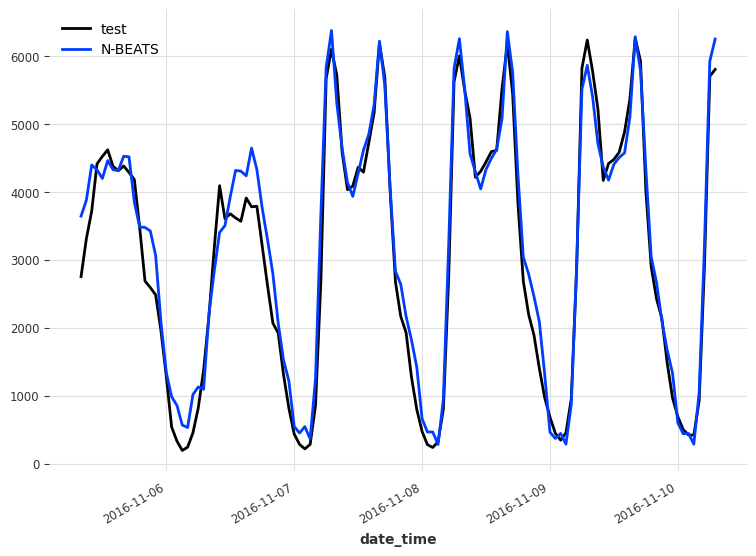

In [19]:
test.plot(label='test')
pred_nbeats.plot(label='N-BEATS')

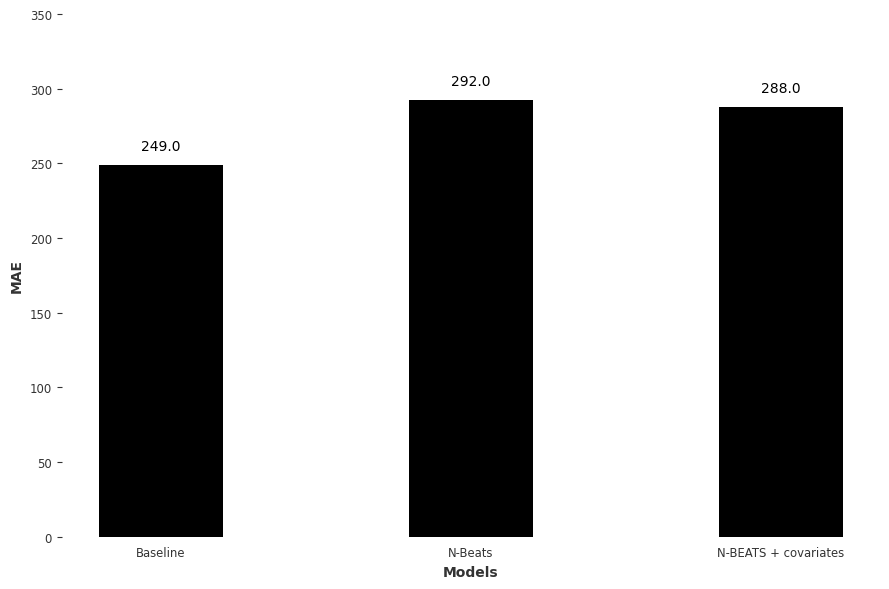

In [20]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-Beats', 'N-BEATS + covariates']
y = [naive_mae, mae_nbeats, mae_nbeats_cov]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 350)
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 10, s=str(round(value,0)), ha='center')

plt.tight_layout()